In [1]:
import cv2
import numpy as np
import pandas as pd

import theano
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_mldata
%matplotlib inline

Using Theano backend.


In [2]:
def resize(image, size=(12, 12)): return cv2.resize(image, size).flatten()

In [3]:
digits = {}
mnist = fetch_mldata('MNIST original', data_home='data/')

digits['target'] = mnist['target'][(mnist['target'] == 0) | (mnist['target'] == 1)]
digits['data'] = mnist['data'][(mnist['target'] == 0) | (mnist['target'] == 1)]

classes, ids = np.unique(digits['target'], return_inverse=True)
labels = np_utils.to_categorical(ids, len(classes))

data = map(resize, digits['data'])
data = np.array(data)/255.0
(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [4]:
model = Sequential()
model.add(Dense(200, input_shape=data[0].shape, kernel_initializer="uniform", activation="tanh"))
model.add(Dense(100, kernel_initializer="uniform", activation="tanh"))
model.add(Dense(labels.shape[1]))
model.add(Activation("softmax"))

In [5]:
sgd = SGD(lr=0.01)
adagrad = Adagrad(lr=0.01)
adam = Adam(lr=0.01)

model.compile(loss="binary_crossentropy", optimizer=adagrad, metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=100, batch_size=128, verbose=1)

print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))

Epoch 1/100
11085/11085 [==============================] - 0s - loss: 0.1201 - acc: 0.9664     
Epoch 2/100
11085/11085 [==============================] - 0s - loss: 0.0825 - acc: 0.9759     

In [6]:
import pymc3 as pm
import theano.tensor as T

In [7]:
trainLabels = classes[trainLabels.argmax(1)]
ann_input = theano.shared(trainData)
ann_output = theano.shared(trainLabels)

In [8]:
d_1 = (trainData.shape[1], 200)
d_2 = (200, 100)
d_3 = (100,)

with pm.Model() as neural_network:
    W_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=d_1, testval=np.random.randn(*d_1))
    W_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=d_2, testval=np.random.randn(*d_2))
    W_2_out = pm.Normal('w_2_out', 0, sd=1, shape=d_3, testval=np.random.randn(*d_3))
    
    act_1 = T.tanh(T.dot(ann_input, W_in_1))
    act_2 = T.tanh(T.dot(act_1, W_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, W_2_out))
    
    """    
    act_1 = T.nnet.relu(T.dot(ann_input, W_in_1))
    act_2 = T.nnet.relu(T.dot(act_1, W_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, W_2_out))
    
    """    
    out = pm.Bernoulli('out', act_out, observed=ann_output) # Binary classification -> Bernoulli likelihood
                                                            # what about multi-class?

/usr/local/lib/python2.7/site-packages/theano/tensor/basic.py:2124: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [9]:
from pymc3 import NUTS, sample,find_MAP,Slice,traceplot
from scipy import optimize

with neural_network:
    v_params = pm.variational.advi(n=1000)

Average ELBO = -37,916: 100%|██████████| 1000/1000 [03:51<00:00,  4.20it/s]
Finished [100%]: Average ELBO = -35,766


In [10]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5001)

100%|██████████| 5001/5001 [00:24<00:00, 200.20it/s]


100%|██████████| 2000/2000 [01:54<00:00, 12.16it/s]


Accuracy = 96.6711772666%


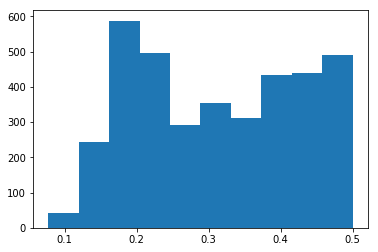

In [11]:
testLabels = classes[testLabels.argmax(1)]
ann_input.set_value(testData)
ann_output.set_value(testLabels)

ppc = pm.sample_ppc(trace, model=neural_network, samples=2000) # Creater posterior predictive samples
pred = ppc['out'].mean(axis=0) > 0.5 # Use probability of > 0.5 to assume prediction of class 1
print('Accuracy = {}%'.format((testLabels == pred).mean() * 100))
plt.hist(ppc['out'].std(axis=0));

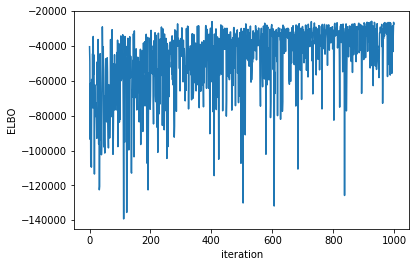

In [12]:
plt.plot(v_params.elbo_vals);
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [13]:
idx = mnist['target'] == 7
sevens = mnist['data'][idx]

out_of_dist = np.array(map(resize, sevens))/255.0

ann_input.set_value(out_of_dist)
ann_output.set_value(np.ones(out_of_dist.shape[1]))

ppc = pm.sample_ppc(trace, model=neural_network, samples=1000)

means = ppc['out'].mean(axis=0)
stds = ppc['out'].std(axis=0)

100%|██████████| 1000/1000 [01:44<00:00,  9.84it/s]


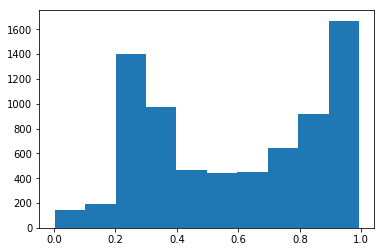

In [14]:
plt.hist(means);

4


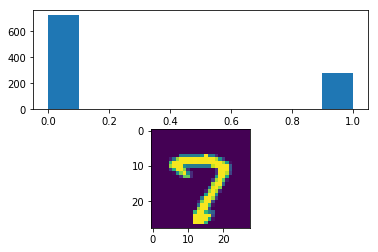

In [15]:
n = 1
confident = [i for i, b in enumerate(stds > 0.4449) if b]
i = confident[n]
print i

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(ppc['out'][:, i]);
ax2.imshow(sevens[i].reshape(28,28));

In [16]:
idx = mnist['target'] == 1
ones = mnist['data'][idx]

#plt.imshow(sevens[0].reshape(28, 28));

in_dist = np.array(map(resize, ones))/255.0

ann_input.set_value(out_of_dist)
ann_output.set_value(np.ones(out_of_dist.shape[1]))

ppc = pm.sample_ppc(trace, model=neural_network, samples=1000)

means = ppc['out'].mean(axis=0)
stds = ppc['out'].std(axis=0)

100%|██████████| 1000/1000 [01:52<00:00,  8.10it/s]


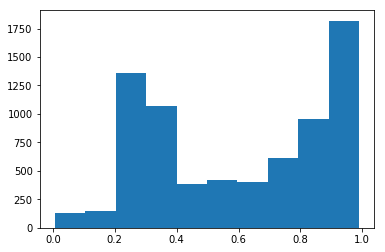

In [17]:
plt.hist(means);

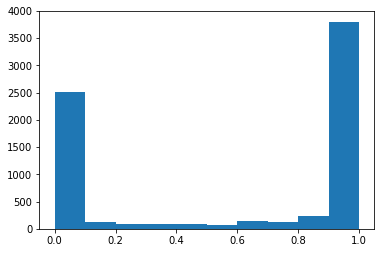

In [18]:
zeros = [a for (a, b) in model.predict(out_of_dist)]
ones = [b for (a, b) in model.predict(out_of_dist)]

plt.hist(ones);   # always very very sure which class it belongs to